In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="{}".format(0) # gpu idx

In [2]:
import tensorflow.keras as keras
import tensorflow as tf

from tensorflow.keras.utils import to_categorical
import numpy as np
import os, sys

from utils.data_helper import read_data, sents2sequences, get_data
from utils.model_helper import plot_attention_weights
from utils.logger import get_logger
from utils.config import Config

In [3]:
from layers.attention import AttentionLayer

In [4]:
from tensorflow.keras.models import load_model

In [5]:
config = Config()

logger = get_logger("examples.nmt.train", config.LOGS_DIR)

examples.nmt.train | INFO | Started log logs/examples.nmt.train


In [6]:
#full_model = load_model(os.path.join(config.MODELS_DIR, 'nmt.h5'), custom_objects={'AttentionLayer':AttentionLayer})
#tf.keras.utils.plot_model(full_model, to_file="images/model_{}_full.png".format("nmt"), show_shapes=True)

infer_enc_model = load_model(os.path.join(config.MODELS_DIR, 'nmt_infer_enc_model.h5'), custom_objects={'AttentionLayer':AttentionLayer})
infer_dec_model = load_model(os.path.join(config.MODELS_DIR, 'nmt_infer_dec_model.h5'), custom_objects={'AttentionLayer':AttentionLayer})

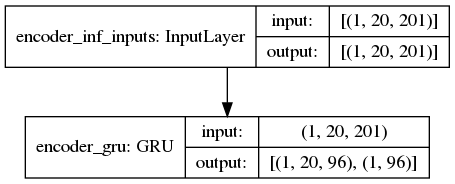

In [7]:
tf.keras.utils.plot_model(infer_enc_model, to_file="images/model_{}_enc.png".format("nmt"), show_shapes=True)

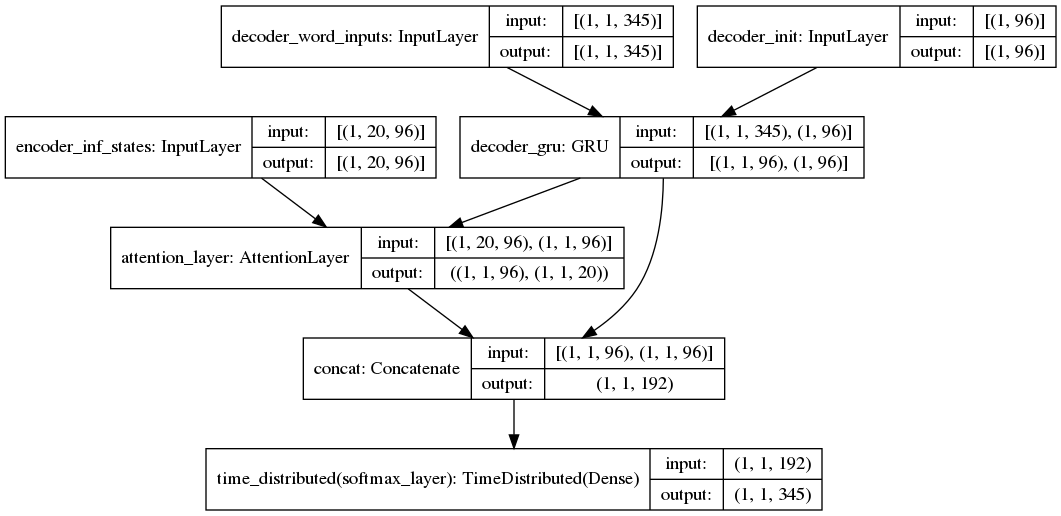

In [8]:
tf.keras.utils.plot_model(infer_dec_model, to_file="images/model_{}_dec.png".format("nmt"), show_shapes=True)

In [9]:
batch_size = 1
hidden_size = 96
en_timesteps, fr_timesteps = 20, 20

en_vsize = 201
fr_vsize = 345


In [10]:
en_text = 'the united states is sometimes chilly during december , but it is sometimes hot in june'
np.shape([en_text])

(1,)

In [11]:
import pickle 

with open('./out/en_tokenizer.pickle', 'rb') as handle:
    en_tokenizer = pickle.load(handle)
with open('./out/fr_tokenizer.pickle', 'rb') as handle:
    fr_tokenizer = pickle.load(handle)

In [12]:
""" Index2word """
en_index2word = dict(zip(en_tokenizer.word_index.values(), en_tokenizer.word_index.keys()))
fr_index2word = dict(zip(fr_tokenizer.word_index.values(), fr_tokenizer.word_index.keys()))

In [13]:
en_index2word

{1: 'UNK',
 2: 'is',
 3: 'in',
 4: 'it',
 5: 'during',
 6: 'the',
 7: 'but',
 8: 'and',
 9: 'usually',
 10: 'sometimes',
 11: 'never',
 12: 'favorite',
 13: 'least',
 14: 'fruit',
 15: 'most',
 16: 'loved',
 17: 'liked',
 18: 'new',
 19: 'paris',
 20: 'california',
 21: 'india',
 22: 'united',
 23: 'states',
 24: 'jersey',
 25: 'france',
 26: 'china',
 27: 'she',
 28: 'he',
 29: 'grapefruit',
 30: 'my',
 31: 'his',
 32: 'your',
 33: 'her',
 34: 'june',
 35: 'fall',
 36: 'winter',
 37: 'spring',
 38: 'march',
 39: 'january',
 40: 'nice',
 41: 'autumn',
 42: 'september',
 43: 'february',
 44: 'may',
 45: 'december',
 46: 'beautiful',
 47: 'our',
 48: 'july',
 49: 'pleasant',
 50: 'november',
 51: 'april',
 52: 'summer',
 53: 'dry',
 54: 'freezing',
 55: 'cold',
 56: 'warm',
 57: 'their',
 58: 'snowy',
 59: 'october',
 60: 'rainy',
 61: 'wonderful',
 62: 'august',
 63: 'wet',
 64: 'busy',
 65: 'relaxing',
 66: 'mild',
 67: 'hot',
 68: 'quiet',
 69: 'chilly',
 70: 'dislikes',
 71: 'likes',

In [14]:
en_tokenizer.fit_on_texts(en_text)

In [15]:
test_en_seq = sents2sequences(en_tokenizer, [en_text], reverse=False, pad_length=en_timesteps) #padding_type='pre',

In [16]:
test_en_seq[0]

array([ 6, 22, 23,  2, 10, 69,  5, 45,  7,  4,  2, 10, 67,  3, 34,  0,  0,
        0,  0,  0], dtype=int32)

In [17]:
def infer_nmt(encoder_model, decoder_model, test_en_seq, en_vsize, fr_vsize):
    """
    Infer logic
    :param encoder_model: keras.Model
    :param decoder_model: keras.Model
    :param test_en_seq: sequence of word ids
    :param en_vsize: int
    :param fr_vsize: int
    :return:
    """

    test_fr_seq = sents2sequences(fr_tokenizer, ['sos'], fr_vsize)
    test_en_onehot_seq = to_categorical(test_en_seq, num_classes=en_vsize)
    test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

    enc_outs, enc_last_state = encoder_model.predict(test_en_onehot_seq)
    dec_state = enc_last_state
    attention_weights = []
    fr_text = ''
    for i in range(20):

        dec_out, attention, dec_state = decoder_model.predict([enc_outs, dec_state, test_fr_onehot_seq])
        dec_ind = np.argmax(dec_out, axis=-1)[0, 0]

        if dec_ind == 0:
            break
        test_fr_seq = sents2sequences(fr_tokenizer, [fr_index2word[dec_ind]], fr_vsize)
        test_fr_onehot_seq = np.expand_dims(to_categorical(test_fr_seq, num_classes=fr_vsize), 1)

        attention_weights.append((dec_ind, attention))
        fr_text += fr_index2word[dec_ind] + ' '

    return fr_text, attention_weights


In [18]:
test_fr, attn_weights = infer_nmt(
    encoder_model=infer_enc_model, decoder_model=infer_dec_model,
    test_en_seq=test_en_seq, en_vsize=en_vsize, fr_vsize=fr_vsize)

In [19]:
print(test_fr)

les états unis est parfois froid en décembre mais il est parfois chaud en juin eos 


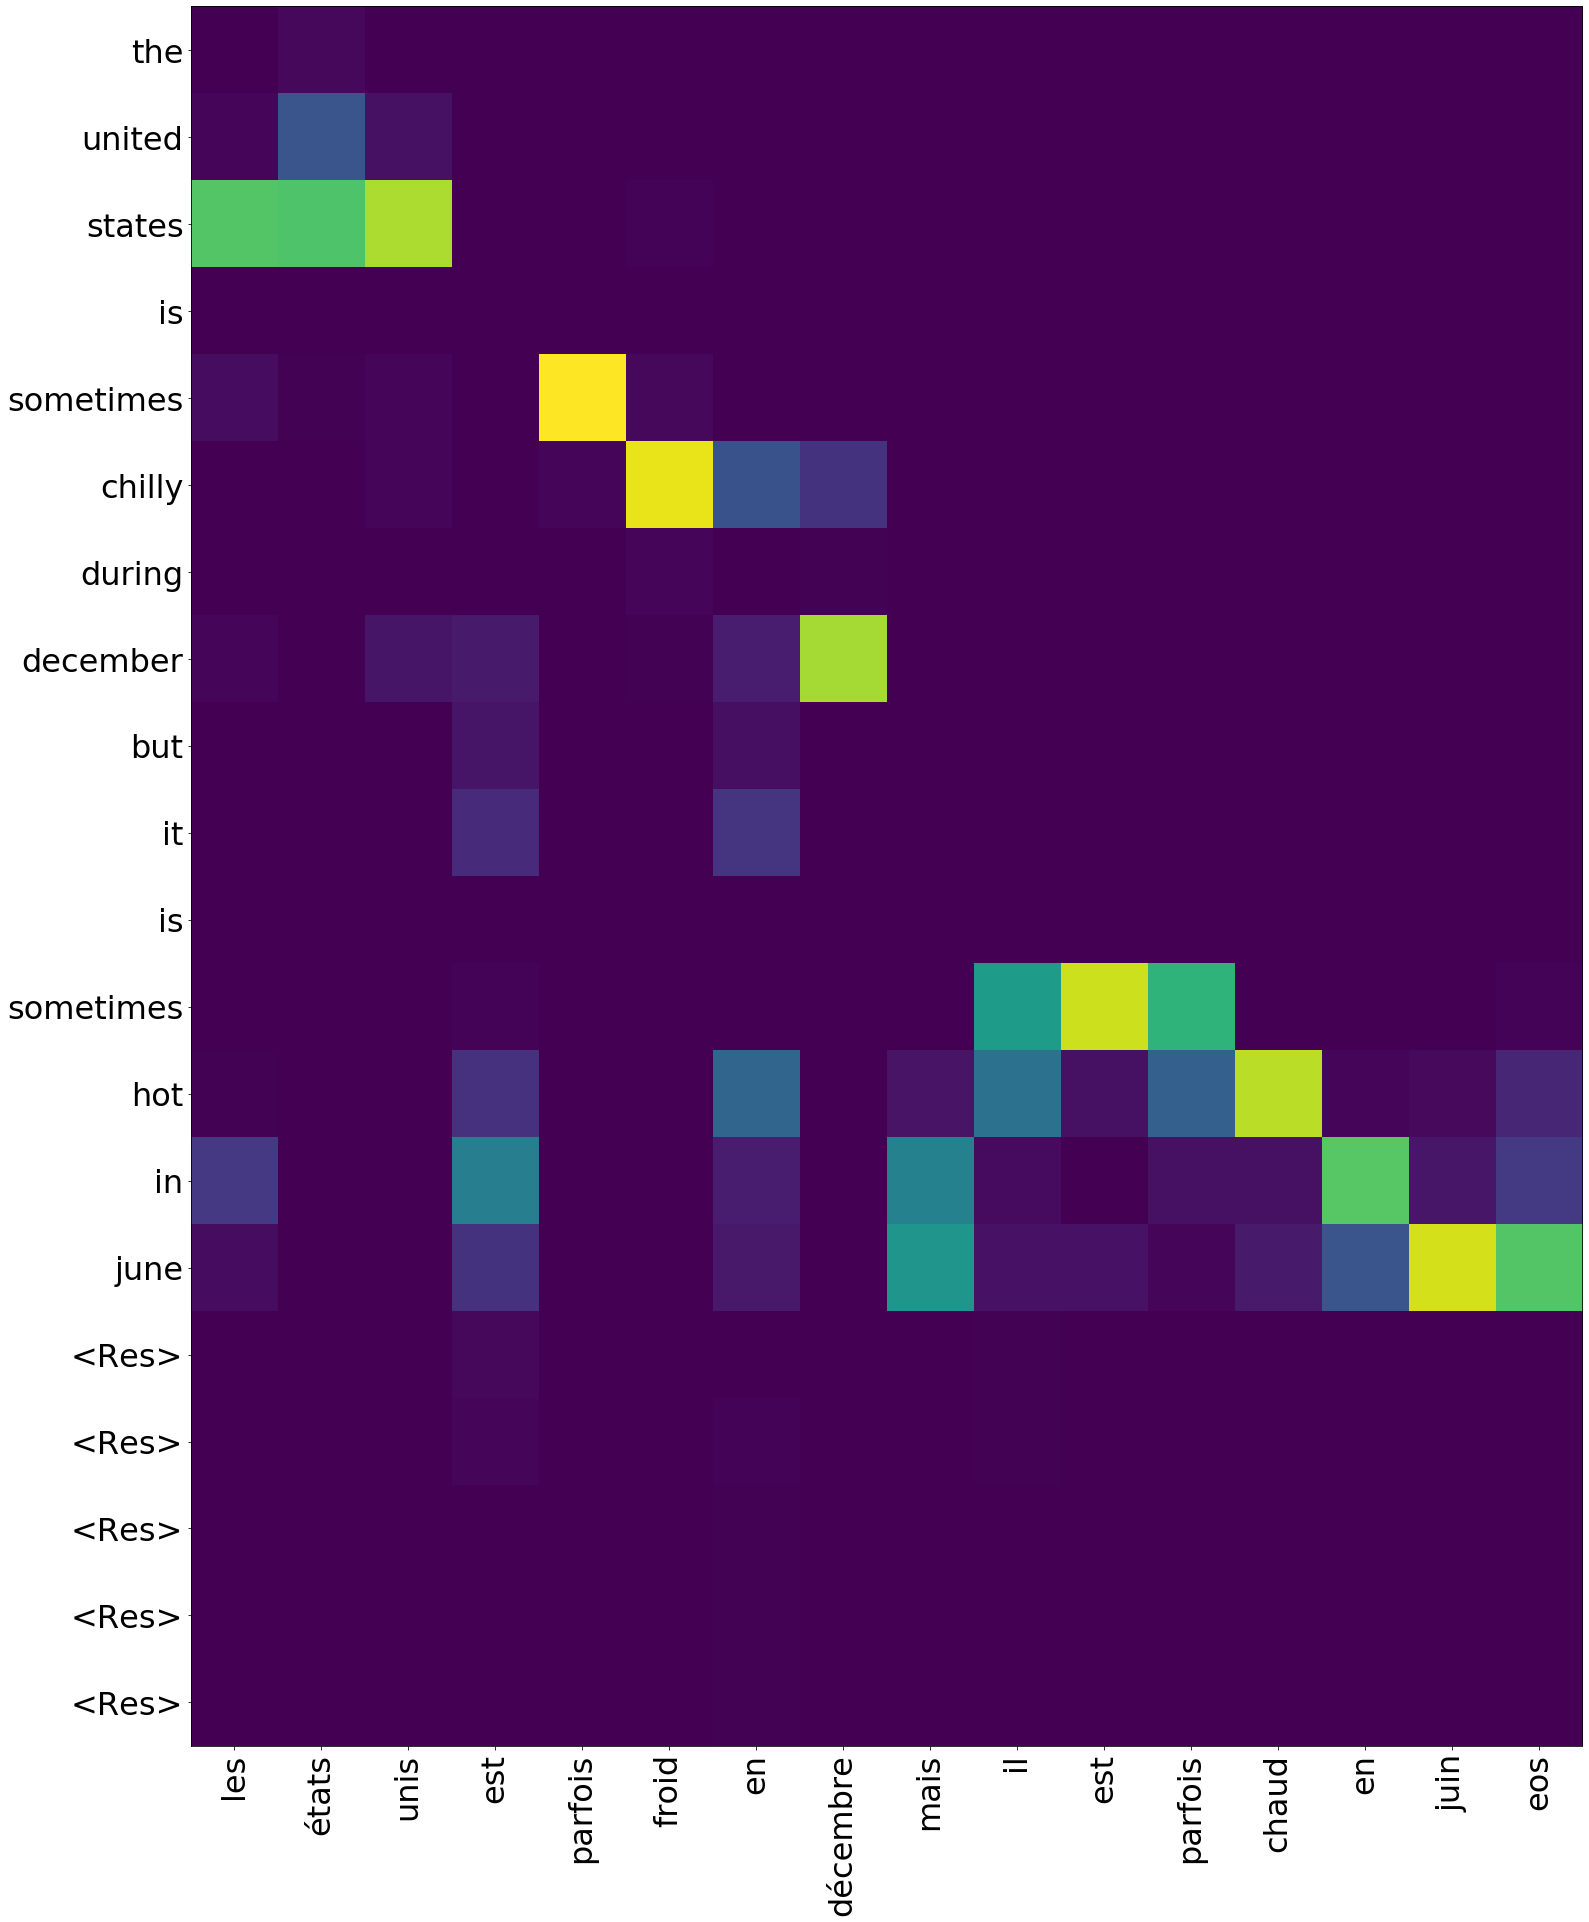

In [20]:
""" Attention plotting """
plot_attention_weights(test_en_seq, attn_weights, en_index2word, fr_index2word)